<img src="images/HeadingSlideSmall.png" width="400">



# Steps In this Demo


1. <font size=4>[Preparing The Data](#Preparing-The-Data)</font>
2. <font size=4>[Building the Model](#Building-the-model)</font>
3. <font size=4>[Training on Amazon SageMaker](#Training-on-Amazon-SageMaker)</font>
4. <font size=4>[Deploy Using Amazon SageMaker](#Deploy-Using-Amazon-SageMaker)</font>
5. <font size=4>[Perform Inference](#Perform-Inference)</font>



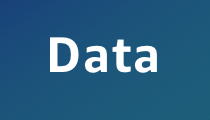

# Preparing The Data
***

We will be using our own custom image classification dataset prepared using SageMaker GroundTruth. The image set that I used had 60 images. How many images do you have?

My split is
* 20 images of grapes
* 20 images of oranges
* 20 images of tomatoes

Let's have a quick look!

### 1.a - Configuring The S3 Bucket


In [ ]:
bucket='djenny-sagemaker-sydney' #'<<bucket-name>>' # customize to your bucket
prefix = 'ChipPackets' # My sample data is labelled packets of chips, what is your data?

### 1.b - Sample of our original dataset 

In [ ]:
file_name = 'images/sample_training_image.jpg' # Show one of your sample images to the readers

from IPython.display import Image
Image(file_name, width=300)  

### 1.c SageMaker Ground Truth output manifest

SageMaker Ground Truth was used to label these images and hence create our training dataset.
Our workforce was tasked with drawing bounding boxes around the chip packets and selecting the label "chip_packet"
The key component of this output is the Ground Truth output.manifest file

Let's download it and take a look

In [ ]:
import boto3
s3 = boto3.client('s3')

In [ ]:
# Download the augmented manifest file that GroundTruth produced (my directory is call ChipPackets, what is yours?)
gt_output_dir = prefix + "/output/ChipPackets/manifests/output" 
s3.download_file(bucket, gt_output_dir + '/manifests/output.manifest', 'output.manifest')

In [ ]:
import json
with open('/manifests/output.manifest') as f:
    first_line = f.readline()
parsed = json.loads(first_line)
print(json.dumps(parsed, indent=4))

### 1.d Prepare training and validation manifest files

Shuffle and then split output.manifest into train.manifest and validation.manifest
Use a 80/20 split

In [ ]:
import numpy as np
import json
with open('/manifests/output.manifest', 'r') as f:
    output = [json.loads(line) for line in f.readlines()]

# Shuffle output in place.
np.random.shuffle(output)
    
dataset_size = len(output)
train_test_split_index = round(dataset_size*0.8)

train_data = output[:train_test_split_index]
validation_data = output[train_test_split_index:]

num_training_samples = 0
with open('/manifests/train.manifest', 'w') as f:
    for line in train_data:
        f.write(json.dumps(line))
        f.write('\n')
        num_training_samples += 1
    
with open('/manifests/validation.manifest', 'w') as f:
    for line in validation_data:
        f.write(json.dumps(line))
        f.write('\n')

Check how many images are in our training dataset - we need to provide this as a hyperparameter to our training job

In [ ]:
print("Number of training samples: ",num_training_samples)

Upload train.manifest and validation.manifest to S3 in preparation for training job

In [ ]:
s3.upload_file('/manifests/train.manifest',bucket, gt_output_dir + '/train.manifest')
s3.upload_file('/manifests/validation.manifest',bucket, gt_output_dir + '/validation.manifest')


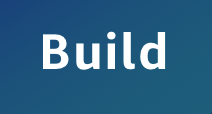

# 2. Building the Model
***



### 2.a - Select our algorithm

We will use Amazon SageMaker's Built Object Detection Algorithm

In [ ]:
import sagemaker
sess = sagemaker.Session()

from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

role = get_execution_role()

training_image = get_image_uri(sess.boto_region_name, 'object-detection')
print(role)
print(training_image)

### 2.b Choose our hyperparameters

* Using the pre-trained option (Transfer Learning)
* Take advantage of the algorithms built-in image augmentation
* Define the algorithm hyperparameters

In [ ]:
s3_model_output_location = 's3://{}/{}/output/model'.format(bucket, prefix)
print(s3_model_output_location)

In [ ]:
od_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p3.2xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode= 'Pipe',
                                         output_path=s3_model_output_location,
                                         sagemaker_session=sess)

In [ ]:
od_model.set_hyperparameters(base_network='resnet-50',
                             use_pretrained_model=1,
                             num_classes=2,
                             mini_batch_size=2,
                             epochs=5,
                             learning_rate=0.001,
                             lr_scheduler_step='3,6',
                             lr_scheduler_factor=0.1,
                             optimizer='sgd',
                             momentum=0.9,
                             weight_decay=0.0005,
                             overlap_threshold=0.5,
                             nms_threshold=0.45,
                             image_shape=300,
                             label_width=350,
                             num_training_samples=num_training_samples)


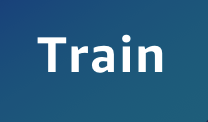

# 3. Training on Amazon SageMaker
***

### 3.a - First Defining The Training Configurations
* Configure the output location

* Configure the training set up

* Setting the hyperparameters

* Training and validation data locations

Note: Tips I used for setting s3_input parameters for a job using Ground Truth output:<br>
[Example using SageMaker low-level boto3 library](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/ground_truth_labeling_jobs/from_unlabeled_data_to_deployed_machine_learning_model_ground_truth_demo_image_classification/from_unlabeled_data_to_deployed_machine_learning_model_ground_truth_demo_image_classification.ipynb "Jupyter Notebook")<br>
[Code samples using SageMaker high-level library](https://github.com/aws/sagemaker-python-sdk/blob/master/tests/unit/test_session.py "Github repo")

In [ ]:
# Make sure you specify the location of YOUR augmented manifest files here
train_data = sagemaker.session.s3_input("s3://djenny-sagemaker-sydney/ChipPackets/output/ChipPackets/manifests/output/train.manifest",
                                        distribution='FullyReplicated',
                                        content_type='application/x-recordio',
                                        s3_data_type='AugmentedManifestFile',
                                        record_wrapping='RecordIO',
                                        attribute_names=['source-ref','ChipPackets']) 

validation_data = sagemaker.session.s3_input("s3://djenny-sagemaker-sydney/ChipPackets/output/ChipPackets/manifests/output/validation.manifest",
                                        distribution='FullyReplicated',
                                        content_type='application/x-recordio',
                                        s3_data_type='AugmentedManifestFile',
                                        record_wrapping='RecordIO',
                                        attribute_names=['source-ref','ChipPackets']) 

data_channels = {'train': train_data, 'validation': validation_data}

### 3.b - Submit the Training Job

In [ ]:
%%time
od_model.fit(inputs=data_channels, logs=True)


<img src="attachment:Screen%20Shot%202018-04-06%20at%205.21.16%20pm.png" align="left">


# 4. Deploy Using Amazon SageMaker

***


Model = Inference Code + Model Artifacts

In [ ]:
object_detector = od_model.deploy(initial_instance_count = 2,  # High Availability
                                 instance_type = 'ml.t2.medium')

# 5. Perform Inference
***

### 5.a - Download The Test Image

In [ ]:
# If you don't have a sample image to test with, download one to this notebook instance now

### 5.b - Invoke the Endpoint

In [ ]:
import json
import numpy as np

file_name = 'images/test_image.jpg' # Hold out one of your images for testing purposes

with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)

object_detector.content_type = 'image/jpeg'

results = object_detector.predict(payload)

detections = json.loads(results)
print (detections)


In [ ]:
def visualize_detection(img_file, dets, classes=[], thresh=0.6):
        """
        visualize detections in one image
        Parameters:
        ----------
        img : numpy.array
            image, in bgr format
        dets : numpy.array
            ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : tuple or list of str
            class names
        thresh : float
            score threshold
        """
        import random
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg

        img=mpimg.imread(img_file)
        plt.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        colors = dict()
        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh:
                continue
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = int(x0 * width)
            ymin = int(y0 * height)
            xmax = int(x1 * width)
            ymax = int(y1 * height)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=3.5)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            if classes and len(classes) > cls_id:
                class_name = classes[cls_id]
            plt.gca().text(xmin, ymin - 2,
                            '{:s} {:.3f}'.format(class_name, score),
                            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                    fontsize=12, color='white')
        plt.show()

In [ ]:
# Make sure you change the categories to your own
object_categories = ['chip_packet', 'unknown']

# Setting a threshold 0.70 will only plot detection results that have a confidence score greater than 70%.
threshold = 0.70

# Visualize the detections.
visualize_detection(file_name, detections['prediction'], object_categories, threshold)

#### Clean up


In [ ]:
sagemaker.Session().delete_endpoint(image_classifier.endpoint)